# 群知能 ACO(Ant Colony Optimization)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
%matplotlib inline

定義とパラメータ

In [20]:
# parameter
num_cities = 20
num_ants = num_cities
alpha = 1.0
beta = 0.5
rho = 0.4
MAX_T = 500

# global variable
cities = np.random.rand(num_cities, 2)
xx, yy = np.meshgrid(np.arange(num_cities), np.arange(num_cities))
distances = np.linalg.norm(cities[xx] - cities[yy], axis=2)
pheromones = np.ones((num_cities, num_cities)) / 1000.0

# ルート選択関数
def select_route(start, alpha=1.0, beta=0.5):
    not_visited = [i for i in range(num_cities)]
    not_visited.remove(start)
    route = [start]
    
    while not_visited:
        # 現在の都市
        current_city = route[-1]
        
        # 次の都市を確率的に選択
        ths = (pheromones[current_city, not_visited]**alpha) * ((1. / distances[current_city, not_visited])**beta)
        next_city = np.random.choice(not_visited, p=[th / ths.sum() for th in ths])
        
        # ルートに都市を追加し, 残存都市から削除
        route.append(next_city)
        not_visited.remove(next_city)
    # 最後に始点の都市
    route.append(start)
    
    return route

# 更新量を計算
@numba.jit
def get_delta(routes):
    delta_pheromones = np.zeros((num_cities, num_cities, num_ants))
    assert len(routes) == num_cities, 'length of "rotues" must be the same as "num_ants"'
    
    for k, route in enumerate(routes):
        delta_pheromones[route[:-1], route[1:], k] = 1. / distances[route[:-1], route[1:]]

    return delta_pheromones.sum(axis=2)

def eval_routes(rotues):
    route_dists = np.array([distances[route[:-1], route[1:]].sum() for route in routes])
    return (route_dists.max(), route_dists.min(), route_dists.mean(), route_dists.argmin())

def draw_image(t, route, max_phero=400):
    a = np.clip(pheromones / max_phero, 0, 1)
    plt.scatter(cities[:, 0], cities[:, 1], alpha=0.5)
    for i in range(num_cities):
        for j in range(num_cities):
            plt.plot([cities[i,0], cities[j, 0]], [cities[i,1], cities[j, 1]], c='red', alpha=a[i, j])

    plt.plot(cities[route][:,0], cities[route][:,1], ls='-.', alpha=0.4)
    plt.grid()
    plt.savefig('results/ACO/t={:>04}.png'.format(t))
    plt.close()

# 実行

t=0   , phr.max:44.7, dist.best=7.446, dist.worst=10.4, dist.mean=9.054
t=50  , phr.max:996.2, dist.best=3.948, dist.worst=5.688, dist.mean=4.776
t=100 , phr.max:882.4, dist.best=4.133, dist.worst=5.945, dist.mean=5.038
t=150 , phr.max:741.1, dist.best=3.729, dist.worst=5.32, dist.mean=4.551
t=200 , phr.max:821.3, dist.best=3.832, dist.worst=5.314, dist.mean=4.481
t=250 , phr.max:1.033e+03, dist.best=3.729, dist.worst=5.593, dist.mean=4.614
t=300 , phr.max:1.025e+03, dist.best=3.729, dist.worst=4.901, dist.mean=4.435
t=350 , phr.max:1.02e+03, dist.best=3.729, dist.worst=5.829, dist.mean=4.574
t=400 , phr.max:1.018e+03, dist.best=3.811, dist.worst=5.457, dist.mean=4.54
t=450 , phr.max:1.032e+03, dist.best=3.729, dist.worst=5.016, dist.mean=4.343


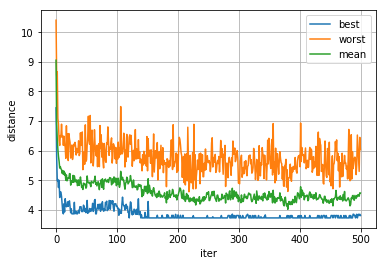

In [21]:
# init
pheromones = np.ones((num_cities, num_cities)) / 1000.0
best_log = []
worst_log = []
mean_log = []
# main 

for t in range(MAX_T):
    # 選択
    routes = [select_route(i) for i in range(num_ants)]
    # 計算
    delta_pheromones = get_delta(routes)
    # 更新
    pheromones = (1.-rho) * pheromones + delta_pheromones
    # 描写
    wdist, bdsit, mdist, bidx = eval_routes(routes)
    best_log.append(bdsit)
    worst_log.append(wdist)
    mean_log.append(mdist)
    draw_image(t, routes[bidx])
    if t % 50 == 0:
        print("t={:<4}, phr.max:{:.4}, dist.best={:.4}, dist.worst={:.4}, dist.mean={:.4}".format(t, pheromones.max(), bdsit, wdist, mdist))

plt.plot(best_log, label='best')
plt.plot(worst_log, label='worst')
plt.plot(mean_log, label='mean')
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel('distance')
plt.show()